<a href="https://colab.research.google.com/github/ogawagen/VQE_trial/blob/main/VQE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 必要なモジュールのインポート
ここが一番重いかも


In [50]:
!python -m pip install python-multipart
!python -m pip install quri-parts[chem,pyscf,qulacs,openfermion]

#インポートと拡張機能の読み込み


In [73]:
#標準ライブラリのインポート
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

#量子化学計算ライブラリのインポート
from pyscf import gto, scf

#QURI Partsライブラリのインポート
from quri_parts.chem.mol import ActiveSpace
from quri_parts.pyscf.mol import get_spin_mo_integrals_from_mole
from quri_parts.openfermion.mol import get_fermionic_hamiltonian, operator_from_of_fermionic_op
from quri_parts.openfermion.transforms import jordan_wigner
from quri_parts.algo.ansatz import HardwareEfficient
from quri_parts.algo.optimizer import LBFGS,OptimizerStatus
from quri_parts.core.state import ParametricCircuitQuantumState
from quri_parts.core.estimator.gradient import create_numerical_gradient_estimator
from quri_parts.qulacs.estimator import create_qulacs_vector_parametric_estimator
from quri_parts.core.estimator.gradient import parameter_shift_gradient_estimates


#分子の初期化とHF計算
古典コンピュータでHF配置の量子化学計算(電子積分)→分子軌道(MO)を得る→その時の係数を得る

In [74]:
def initialize_molecule(molecule, basis='sto-3g'):
    mol = gto.M(atom=molecule, basis=basis, verbose=0)
    mf = scf.RHF(mol).run()
    mo_coeff = mf.mo_coeff
    return mol, mf, mo_coeff


#Active Spaceの定義
Active Spaceの電子と軌道を決める→Active Space内のMOの電子積分を計算

In [75]:
def define_active_space(mol, mo_coeff, n_active_ele, n_active_orb):
    active_space = ActiveSpace(n_active_ele, n_active_orb)
    active_space, active_space_mo_eint_set = get_spin_mo_integrals_from_mole(mol, mo_coeff, active_space)
    return active_space, active_space_mo_eint_set


ここまででMOの電子積分を求めた。ここから分子のハミルトニアンを生成する。

#fermionicハミルトニアンの生成
fermionicハミルトニアンは```active_space_mo_eint_set```

Active Space内のMOの電子積分値から生成できる


#qubitハミルトニアンを生成
量子状態の期待値を見積もることができる

```operator_from_of_fermionic_op```を用いて、fermionハミルトニアンからqubitハミルトニアンへmappingする。

この```active_space_jw_hamiltonian```はfermion-qubitハミルトニアンマッピングを行うことができるアブジェクト

In [76]:
def create_hamiltonians(active_space_mo_eint_set, n_active_orb):
    active_space_fermionic_hamiltonian = get_fermionic_hamiltonian(active_space_mo_eint_set)
    active_space_jw_hamiltonian, active_space_mapping = operator_from_of_fermionic_op(
        active_space_fermionic_hamiltonian,
        active_space,
        fermion_qubit_mapping=jordan_wigner
    )
    return active_space_jw_hamiltonian


#VQEのセットアップ

In [77]:
def setup_vqe(n_active_orb, hw_reps=5, gtol=1e-4):
    hw_ansatz = HardwareEfficient(qubit_count=int(n_active_orb)*2, reps=hw_reps)
    parametric_state = ParametricCircuitQuantumState(n_qubits=int(n_active_orb)*2, circuit=hw_ansatz)
    lbfgs_optimizer = LBFGS(gtol=gtol)
    return hw_ansatz, parametric_state, lbfgs_optimizer


#estimator関数

In [78]:
def create_estimators(delta=1e-4):
    # Concurrent Parametric Estimatorの作成
    ql_concurrent_estimator = create_qulacs_vector_concurrent_parametric_estimator()

    # Gradient Estimatorの作成
    gradient_estimator = create_numerical_gradient_estimator(
        ql_concurrent_estimator, delta=delta
    )
    return ql_concurrent_estimator, gradient_estimator


#VQEの実行

In [79]:
def run_vqe(active_space_jw_hamiltonian, parametric_state, estimator, init_params, optimizer):

    noiseless_result, energy_hist = vqe(active_space_jw_hamiltonian, parametric_state, estimator, init_params, optimizer)

    return noiseless_result, energy_hist


#VQEの初期化と実行
VQE関連の関数を別のセルに配置し、別のセルでVQEを実行

In [80]:
def cost_fn(hamiltonian, parametric_state, param_values, estimator):
    estimate = estimator(active_space_jw_hamiltonian, parametric_state, [param_values])

    return estimate[0].value.real

def grad_fn(hamiltonian, parametric_state, param_values, estimator):
    grad = parameter_shift_gradient_estimates(active_space_jw_hamiltonian, parametric_state, param_values, estimator)
    # parameter shift rule to calculate the gradient

    return np.asarray([i.real for i in grad.values])

def vqe(hamiltonian, parametric_state, estimator, init_params, optimizer):
    opt_state = optimizer.get_init_state(init_params)
    energy_hist = []
    max_iterations = 200  # 最大イテレーション数
    def c_fn(param_values):
         return cost_fn(active_space_jw_hamiltonian, parametric_state, param_values, estimator)

    def g_fn(param_values):
         return grad_fn(active_space_jw_hamiltonian, parametric_state, param_values, estimator)
    for iteration in range(max_iterations):
        opt_state = optimizer.step(opt_state, c_fn, g_fn)

        energy_hist.append(opt_state.cost)

        if opt_state.status == OptimizerStatus.FAILED:
            print("Optimizer failed")
            break
        if opt_state.status == OptimizerStatus.CONVERGED:
            print("Optimizer converged")
            break

    if opt_state.status != OptimizerStatus.CONVERGED:
        print("VQE did not converge within the maximum number of iterations")

    return opt_state, energy_hist


#結果のプロット

In [81]:
def plot_results(energy_hist, exact_energy):
    plt.plot(energy_hist, color="red", label="VQE")
    plt.plot(range(len(energy_hist)), [exact_energy]*len(energy_hist), linestyle="dashed", color="black", label="Exact Solution")
    plt.xlabel("Iteration")
    plt.ylabel("Energy expectation value")
    plt.legend()
    plt.show()


#水素分子の実行

Optimizer converged


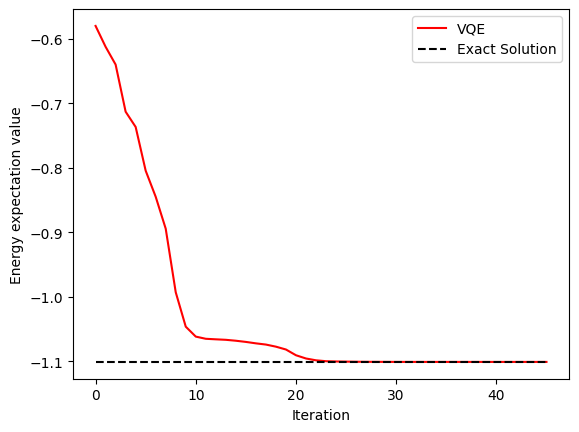

In [82]:
# 分子の初期化
mol, mf, mo_coeff = initialize_molecule([['H', [0, 0, 0]], ['H', [0, 0, 1]]])
#アクティブスペースの電子数と軌道数
n_active_ele = 2
n_active_orb = 2
#set ql_concurrent_estimator
ql_concurrent_estimator = create_qulacs_vector_concurrent_parametric_estimator()
# VQEのセットアップ
hw_ansatz, parametric_state, lbfgs_optimizer = setup_vqe(n_active_orb)
# 初期パラメータの設定
init_params = [0.1] * hw_ansatz.parameter_count
# この値は、実際のパラメータの数に基づいて調整する
param_values = np.random.rand(hw_ansatz.parameter_count)
# active_spaceとactive_space_mo_eint_setを設定
active_space, active_space_mo_eint_set = define_active_space(mol, mo_coeff, n_active_ele, n_active_orb)

# active_space_fermionic_hamiltonianの設定
active_space_fermionic_hamiltonian = get_fermionic_hamiltonian(active_space_mo_eint_set)

# アクティブスペースの定義
active_space, active_space_mo_eint_set = define_active_space(mol, mf.mo_coeff, n_active_ele, n_active_orb)
# ハミルトニアンの生成
active_space_jw_hamiltonian = create_hamiltonians(active_space_mo_eint_set, n_active_orb)

# VQEのセットアップ
hw_ansatz, parametric_state, lbfgs_optimizer = setup_vqe(n_active_orb)

#optimatorの呼び出し
ql_concurrent_estimator, gradient_estimator = create_estimators(delta=1e-4)

# VQEの実行
noiseless_result, energy_hist = run_vqe(active_space_jw_hamiltonian, parametric_state, ql_concurrent_estimator, init_params, lbfgs_optimizer)

# 結果のプロット
exact_energy, _ = get_ground_state(get_sparse_operator(active_space_fermionic_hamiltonian))
plot_results(energy_hist, exact_energy)

#水分子


Optimizer converged


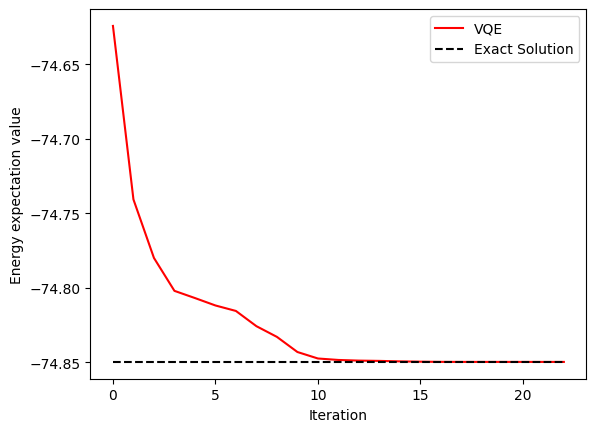

In [87]:
# 分子の初期化
mol, mf, mo_coeff = initialize_molecule([['H', [0, 0, 0]], ['O', [2, 0, 1]], ['H', [0, 0, 1]]])
#アクティブスペースの電子数と軌道数
n_active_ele = 2
n_active_orb = 2
#set ql_concurrent_estimator
ql_concurrent_estimator = create_qulacs_vector_concurrent_parametric_estimator()
# VQEのセットアップ
hw_ansatz, parametric_state, lbfgs_optimizer = setup_vqe(n_active_orb)
# 初期パラメータの設定
init_params = [0.1] * hw_ansatz.parameter_count
# この値は、実際のパラメータの数に基づいて調整する
param_values = np.random.rand(hw_ansatz.parameter_count)
# active_spaceとactive_space_mo_eint_setを設定
active_space, active_space_mo_eint_set = define_active_space(mol, mo_coeff, n_active_ele, n_active_orb)

# active_space_fermionic_hamiltonianの設定
active_space_fermionic_hamiltonian = get_fermionic_hamiltonian(active_space_mo_eint_set)

# アクティブスペースの定義
active_space, active_space_mo_eint_set = define_active_space(mol, mf.mo_coeff, n_active_ele, n_active_orb)
# ハミルトニアンの生成
active_space_jw_hamiltonian = create_hamiltonians(active_space_mo_eint_set, n_active_orb)

# VQEのセットアップ
hw_ansatz, parametric_state, lbfgs_optimizer = setup_vqe(n_active_orb)

#optimatorの呼び出し
ql_concurrent_estimator, gradient_estimator = create_estimators(delta=1e-4)

# VQEの実行
noiseless_result, energy_hist = run_vqe(active_space_jw_hamiltonian, parametric_state, ql_concurrent_estimator, init_params, lbfgs_optimizer)

# 結果のプロット
exact_energy, _ = get_ground_state(get_sparse_operator(active_space_fermionic_hamiltonian))
plot_results(energy_hist, exact_energy)